Research topic:

*   What are the key performance indicators that predict match outcomes in the French Open?
  - rank, age, 1stServeIn, #bpSaved, height etc



*   What performance indicator is the most significant to the match outcome?



*   Can we predict the outcome of this year's French Open (Roland Garros) using athletes stats?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error

In [33]:
# https://www.kaggle.com/datasets/deltaromeo/tennis-atp-tour-singles-1968-2024/data?select=atp_singles.csv
atp_singles_file_path = '/content/drive/MyDrive/Sports Analysis/atp_singles.csv'
atp_df = pd.read_csv(atp_singles_file_path)

# convert date to standard format
atp_df['tourney_date'] = pd.to_datetime(atp_df['tourney_date'].astype(str), format='%Y%m%d')

# rows of French_Open_df after 20000101
atp_df = atp_df[atp_df['tourney_date'] >= pd.to_datetime('2000-01-01')]

# filteration
French_Open_df = atp_df[atp_df['tourney_name'] == 'Roland Garros']

cols_to_keep = [
    'tourney_date', 'winner_name', 'winner_id', 'winner_hand', 'winner_ht', 'winner_age',
    'loser_name', 'loser_id', 'loser_hand', 'loser_ht', 'loser_age', 'w_1stIn', 'w_1stWon',
    'w_2ndWon', 'w_svpt', 'w_ace', 'w_df','w_bpSaved', 'w_bpFaced', 'winner_rank',
    'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_svpt','l_ace', 'l_df', 'l_bpFaced', 'l_bpSaved',
    'loser_rank']
French_Open_df = French_Open_df[cols_to_keep]

# rows with data missing are removed
French_Open_df = French_Open_df.dropna()

French_Open_df

,tourney_date,winner_name,winner_id,winner_hand,winner_ht,winner_age,loser_name,loser_id,loser_hand,loser_ht,...,winner_rank,l_1stIn,l_1stWon,l_2ndWon,l_svpt,l_ace,l_df,l_bpFaced,l_bpSaved,loser_rank
122220,2000-05-29,Andre Agassi,101736,R,180.0,30.0,Antony Dupuis,102179,R,185.0,...,1.0,52.0,38.0,22.0,100.0,9.0,6.0,13.0,9.0,116.0
122221,2000-05-29,Karol Kucera,102344,R,188.0,26.2,Oscar Serrano,103202,R,173.0,...,40.0,50.0,13.0,9.0,66.0,0.0,1.0,23.0,14.0,219.0
122222,2000-05-29,Jiri Vanek,103181,R,185.0,22.0,Alberto Berasategui,102238,R,173.0,...,88.0,120.0,65.0,15.0,175.0,1.0,8.0,25.0,12.0,83.0
122223,2000-05-29,Franco Squillari,102644,L,183.0,24.7,Alexander Popp,102880,R,201.0,...,45.0,50.0,27.0,17.0,86.0,2.0,4.0,17.0,9.0,110.0
122224,2000-05-29,Nicolas Massu,103454,R,183.0,20.6,Jacobo Diaz,102831,R,173.0,...,75.0,60.0,36.0,10.0,89.0,2.0,5.0,12.0,5.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193344,2024-05-27,Alexander Shevchenko,207686,R,185.0,23.4,Aslan Karatsev,106234,R,185.0,...,59.0,89.0,59.0,13.0,130.0,1.0,3.0,15.0,6.0,82.0
193345,2024-05-27,Henri Squire,202260,R,196.0,23.6,Max Purcell,126845,R,185.0,...,221.0,85.0,53.0,42.0,157.0,7.0,3.0,12.0,5.0,94.0
193346,2024-05-27,Jan Lennard Struff,105526,R,193.0,34.0,Roman Andres Burruchaga,208882,R,183.0,...,41.0,57.0,31.0,9.0,83.0,0.0,4.0,16.0,10.0,144.0
193347,2024-05-27,Stan Wawrinka,104527,R,183.0,39.1,Andy Murray,104918,R,191.0,...,98.0,45.0,32.0,18.0,81.0,5.0,1.0,10.0,6.0,75.0


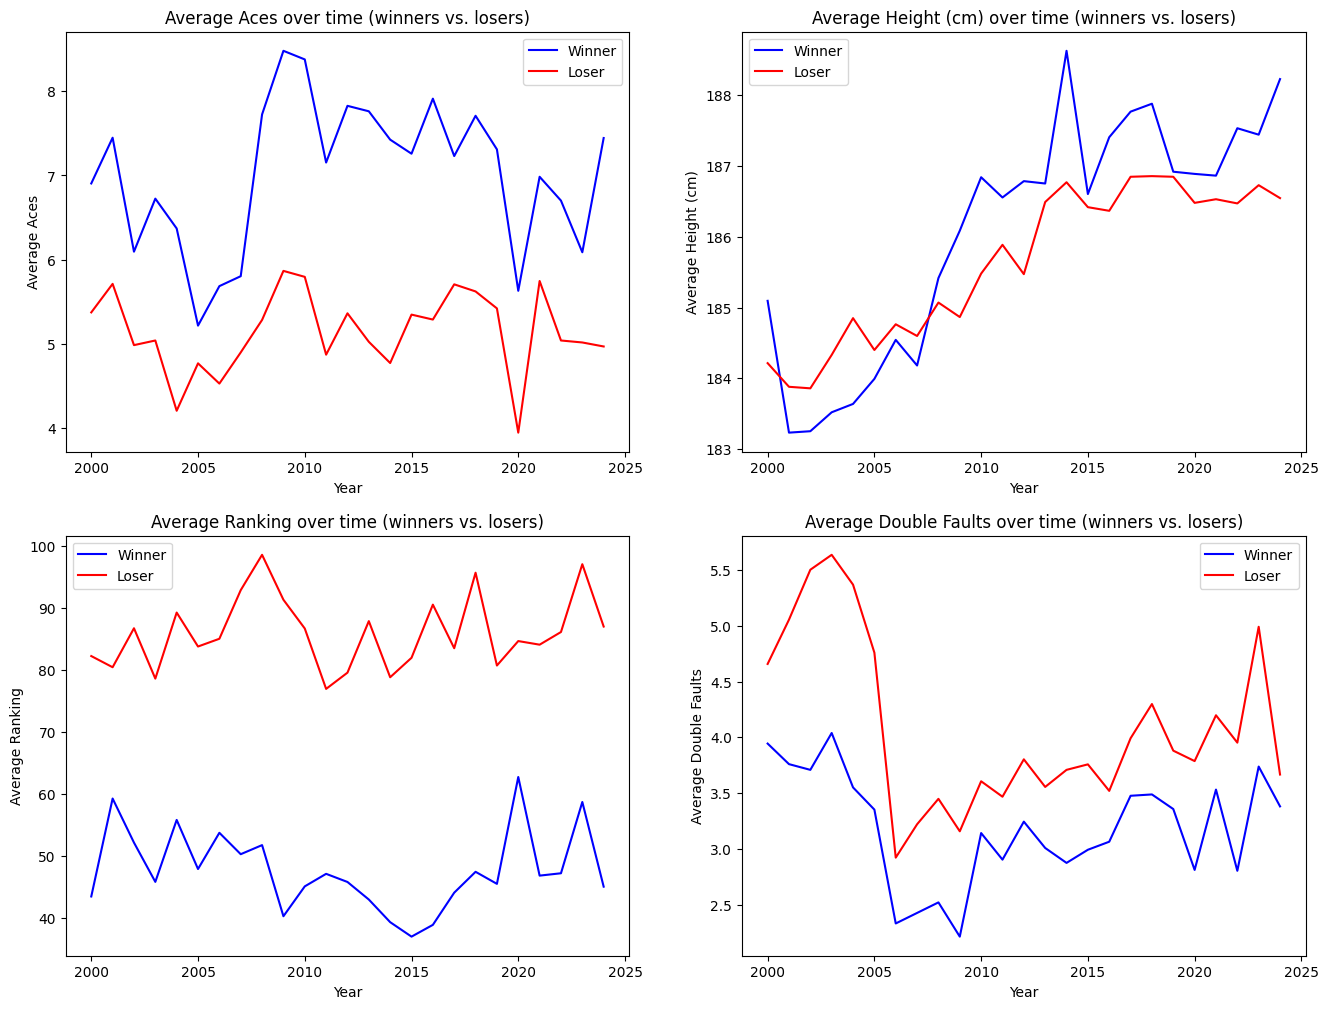

In [34]:
# Compare some stats between winners and losers
# Trends over time

# Group by year and calculate average of each indicater
French_Open_df['year'] = French_Open_df['tourney_date'].dt.year

columns = ['w_ace', 'l_ace', 'winner_ht', 'loser_ht',
           'winner_rank', 'loser_rank', 'w_df', 'l_df']
data_by_year = French_Open_df.groupby('year')[columns].mean().reset_index()

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(16, 12))

axes = [ax1, ax2, ax3, ax4]
w_columns = ['w_ace', 'winner_ht', 'winner_rank', 'w_df']
l_columns = ['l_ace', 'loser_ht', 'loser_rank', 'l_df']
ylabels = ['Average Aces', 'Average Height (cm)', 'Average Ranking', 'Average Double Faults']

for ax, w_col, l_col, ylabel in zip(axes, w_columns, l_columns, ylabels):
    ax.plot(data_by_year['year'], data_by_year[w_col], label='Winner', color='blue')
    ax.plot(data_by_year['year'], data_by_year[l_col], label='Loser', color='red')
    ax.set(title=ylabel + ' over time (winners vs. losers)', xlabel='Year', ylabel=ylabel)
    ax.legend()
plt.show()

In [35]:
# Compute feature differences
# hand difference
hand_map = {'R': 0, 'L': 1}
French_Open_df['hand_diff'] = French_Open_df['winner_hand'].map(hand_map) - French_Open_df['loser_hand'].map(hand_map)

# aces, height, rank, double faults, age differences
French_Open_df['ace_diff'] = French_Open_df['w_ace'] - French_Open_df['l_ace']
French_Open_df['ht_diff'] = French_Open_df['winner_ht'] - French_Open_df['loser_ht']
French_Open_df['rank_diff'] = French_Open_df['winner_rank'] - French_Open_df['loser_rank']
French_Open_df['df_diff'] = French_Open_df['w_df'] - French_Open_df['l_df']
French_Open_df['age_diff'] = French_Open_df['winner_age'] - French_Open_df['loser_age']

# efficiency of first serve in
w_eff = French_Open_df['w_1stIn'] / French_Open_df['w_svpt']
l_eff = French_Open_df['l_1stIn'] / French_Open_df['l_svpt']
French_Open_df['1st_Serve_Eff_diff'] = w_eff - l_eff

# 1st serve success rate
w_success = French_Open_df['w_1stWon'] / French_Open_df['w_1stIn']
l_success = French_Open_df['l_1stWon'] / French_Open_df['l_1stIn']
French_Open_df['1st_Success_diff'] = w_success - l_success

# break points saved rate
w_bpSaved_Pct = French_Open_df['w_bpSaved'] / French_Open_df['w_bpFaced']
l_bpSaved_Pct = French_Open_df['l_bpSaved'] / French_Open_df['l_bpFaced']
French_Open_df['bpSaved_Pct_diff'] = w_bpSaved_Pct - l_bpSaved_Pct

French_Open_df

,tourney_date,winner_name,winner_id,winner_hand,winner_ht,winner_age,loser_name,loser_id,loser_hand,loser_ht,...,year,hand_diff,ace_diff,ht_diff,rank_diff,df_diff,age_diff,1st_Serve_Eff_diff,1st_Success_diff,bpSaved_Pct_diff
122220,2000-05-29,Andre Agassi,101736,R,180.0,30.0,Antony Dupuis,102179,R,185.0,...,2000,0,-1.0,-5.0,-115.0,-3.0,2.8,0.156768,0.000574,-0.192308
122221,2000-05-29,Karol Kucera,102344,R,188.0,26.2,Oscar Serrano,103202,R,173.0,...,2000,0,11.0,15.0,-179.0,3.0,4.2,-0.154401,0.450526,0.057971
122222,2000-05-29,Jiri Vanek,103181,R,185.0,22.0,Alberto Berasategui,102238,R,173.0,...,2000,0,8.0,12.0,5.0,-3.0,-4.9,-0.105467,0.160461,0.058462
122223,2000-05-29,Franco Squillari,102644,L,183.0,24.7,Alexander Popp,102880,R,201.0,...,2000,1,0.0,-18.0,-65.0,0.0,1.2,-0.021395,0.120714,0.042017
122224,2000-05-29,Nicolas Massu,103454,R,183.0,20.6,Jacobo Diaz,102831,R,173.0,...,2000,0,3.0,10.0,-55.0,-4.0,-3.2,-0.168539,0.066667,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193344,2024-05-27,Alexander Shevchenko,207686,R,185.0,23.4,Aslan Karatsev,106234,R,185.0,...,2024,0,12.0,0.0,-23.0,1.0,-7.3,-0.131820,-0.056180,0.236364
193345,2024-05-27,Henri Squire,202260,R,196.0,23.6,Max Purcell,126845,R,185.0,...,2024,0,3.0,11.0,127.0,3.0,-2.5,0.102894,0.084804,0.198718
193346,2024-05-27,Jan Lennard Struff,105526,R,193.0,34.0,Roman Andres Burruchaga,208882,R,183.0,...,2024,0,9.0,10.0,-103.0,-2.0,11.7,-0.143890,0.271930,0.375000
193347,2024-05-27,Stan Wawrinka,104527,R,183.0,39.1,Andy Murray,104918,R,191.0,...,2024,0,-2.0,-8.0,23.0,1.0,2.1,-0.016230,0.080556,0.400000


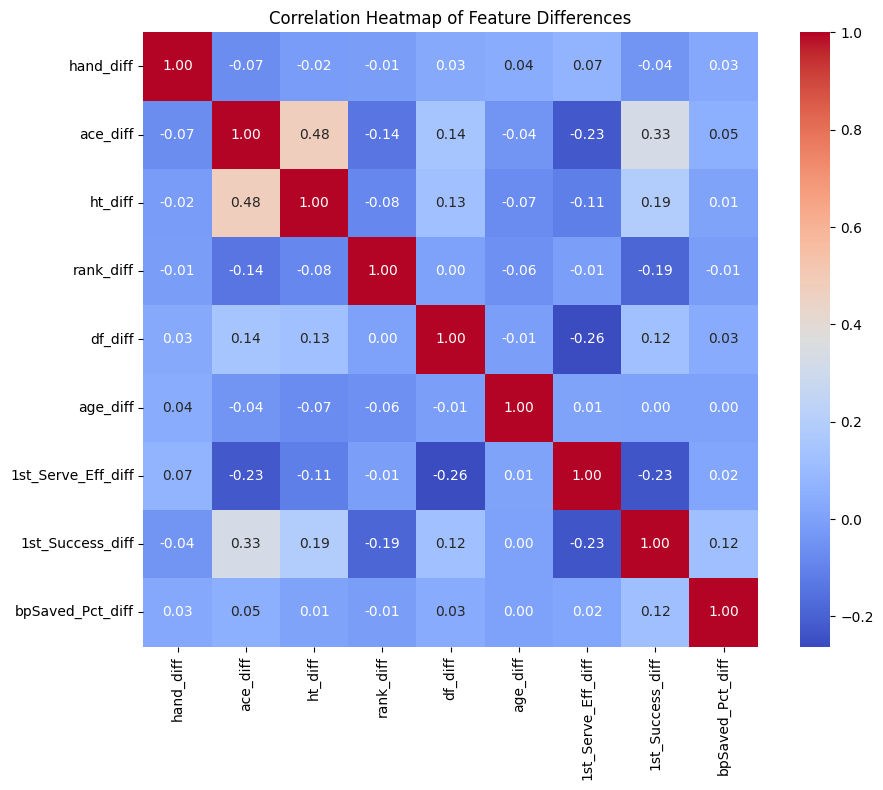

In [37]:
# heatmap of correlation
feature_list = [
    'hand_diff', 'ace_diff', 'ht_diff', 'rank_diff', 'df_diff', 'age_diff',
    '1st_Serve_Eff_diff', '1st_Success_diff', 'bpSaved_Pct_diff'
]

heatmap_df = French_Open_df[feature_list].replace([np.inf, -np.inf], np.nan).dropna()

corr_matrix = heatmap_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap of Feature Differences")
plt.tight_layout()
plt.show()

In [36]:
# Load the filtered dataset
winners_df = French_Open_df.copy()

# Select key features and create label
features = ['hand_diff', 'ht_diff', 'age_diff', 'rank_diff']
winners_df['winner'] = 1

# Duplicate to create another df for loser info
losers_df = winners_df.copy()
losers_df[features] = -losers_df[features]
losers_df['winner'] = 0
combined_df = pd.concat([winners_df, losers_df], ignore_index=True)

# Standardize
scaler = StandardScaler()
combined_df[features] = scaler.fit_transform(combined_df[features])


# logistic regression model
X_train, X_test, y_train, y_test = train_test_split(combined_df[features], combined_df['winner'], test_size=0.2)
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

# calculate MSE value
logistic_model_MSE = mean_squared_error(y_test, y_pred)
print('MSE of Logistic Regression Model:')
print(logistic_model_MSE)



# decision tree
X = combined_df[features]
y = combined_df['winner']

tree_model = DecisionTreeClassifier(max_depth=3).fit(X,y)
y_pred = tree_model.predict(X)

# calculate MSE value
tree_model_MSE = mean_squared_error(y, y_pred)
print('MSE of Decision Tree Model:')
print(tree_model_MSE)

MSE of Logistic Regression Model:
0.29612034837688045
MSE of Decision Tree Model:
0.28342839036755385


[Text(0.5, 0.875, 'rank_diff <= -0.014\nsamples = 100.0%\nvalue = [0.5, 0.5]\nclass = Loser'),
 Text(0.25, 0.625, 'rank_diff <= -0.356\n49.4%\n[0.284, 0.716]\nWinner'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'age_diff <= 2.778\n28.9%\n[0.225, 0.775]\nWinner'),
 Text(0.0625, 0.125, '28.7%\n[0.222, 0.778]\nWinner'),
 Text(0.1875, 0.125, '0.2%\n[0.615, 0.385]\nLoser'),
 Text(0.375, 0.375, 'age_diff <= 1.169\n20.6%\n[0.366, 0.634]\nWinner'),
 Text(0.3125, 0.125, '18.5%\n[0.348, 0.652]\nWinner'),
 Text(0.4375, 0.125, '2.1%\n[0.522, 0.478]\nLoser'),
 Text(0.75, 0.625, 'rank_diff <= 0.356\n50.6%\n[0.712, 0.288]\nLoser'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'age_diff <= -1.169\n21.7%\n[0.627, 0.373]\nLoser'),
 Text(0.5625, 0.125, '2.2%\n[0.486, 0.514]\nWinner'),
 Text(0.6875, 0.125, '19.4%\n[0.644, 0.356]\nLoser'),
 Text(0.875, 0.375, 'age_diff <= -2.778\n28.9%\n[0.775, 0.225]\nLoser'),
 Text(0.8125, 0.125, '0.2%\n[0.385, 0.615]\nWinner'),
 Text(0.9375, 0.125, '28.7%\

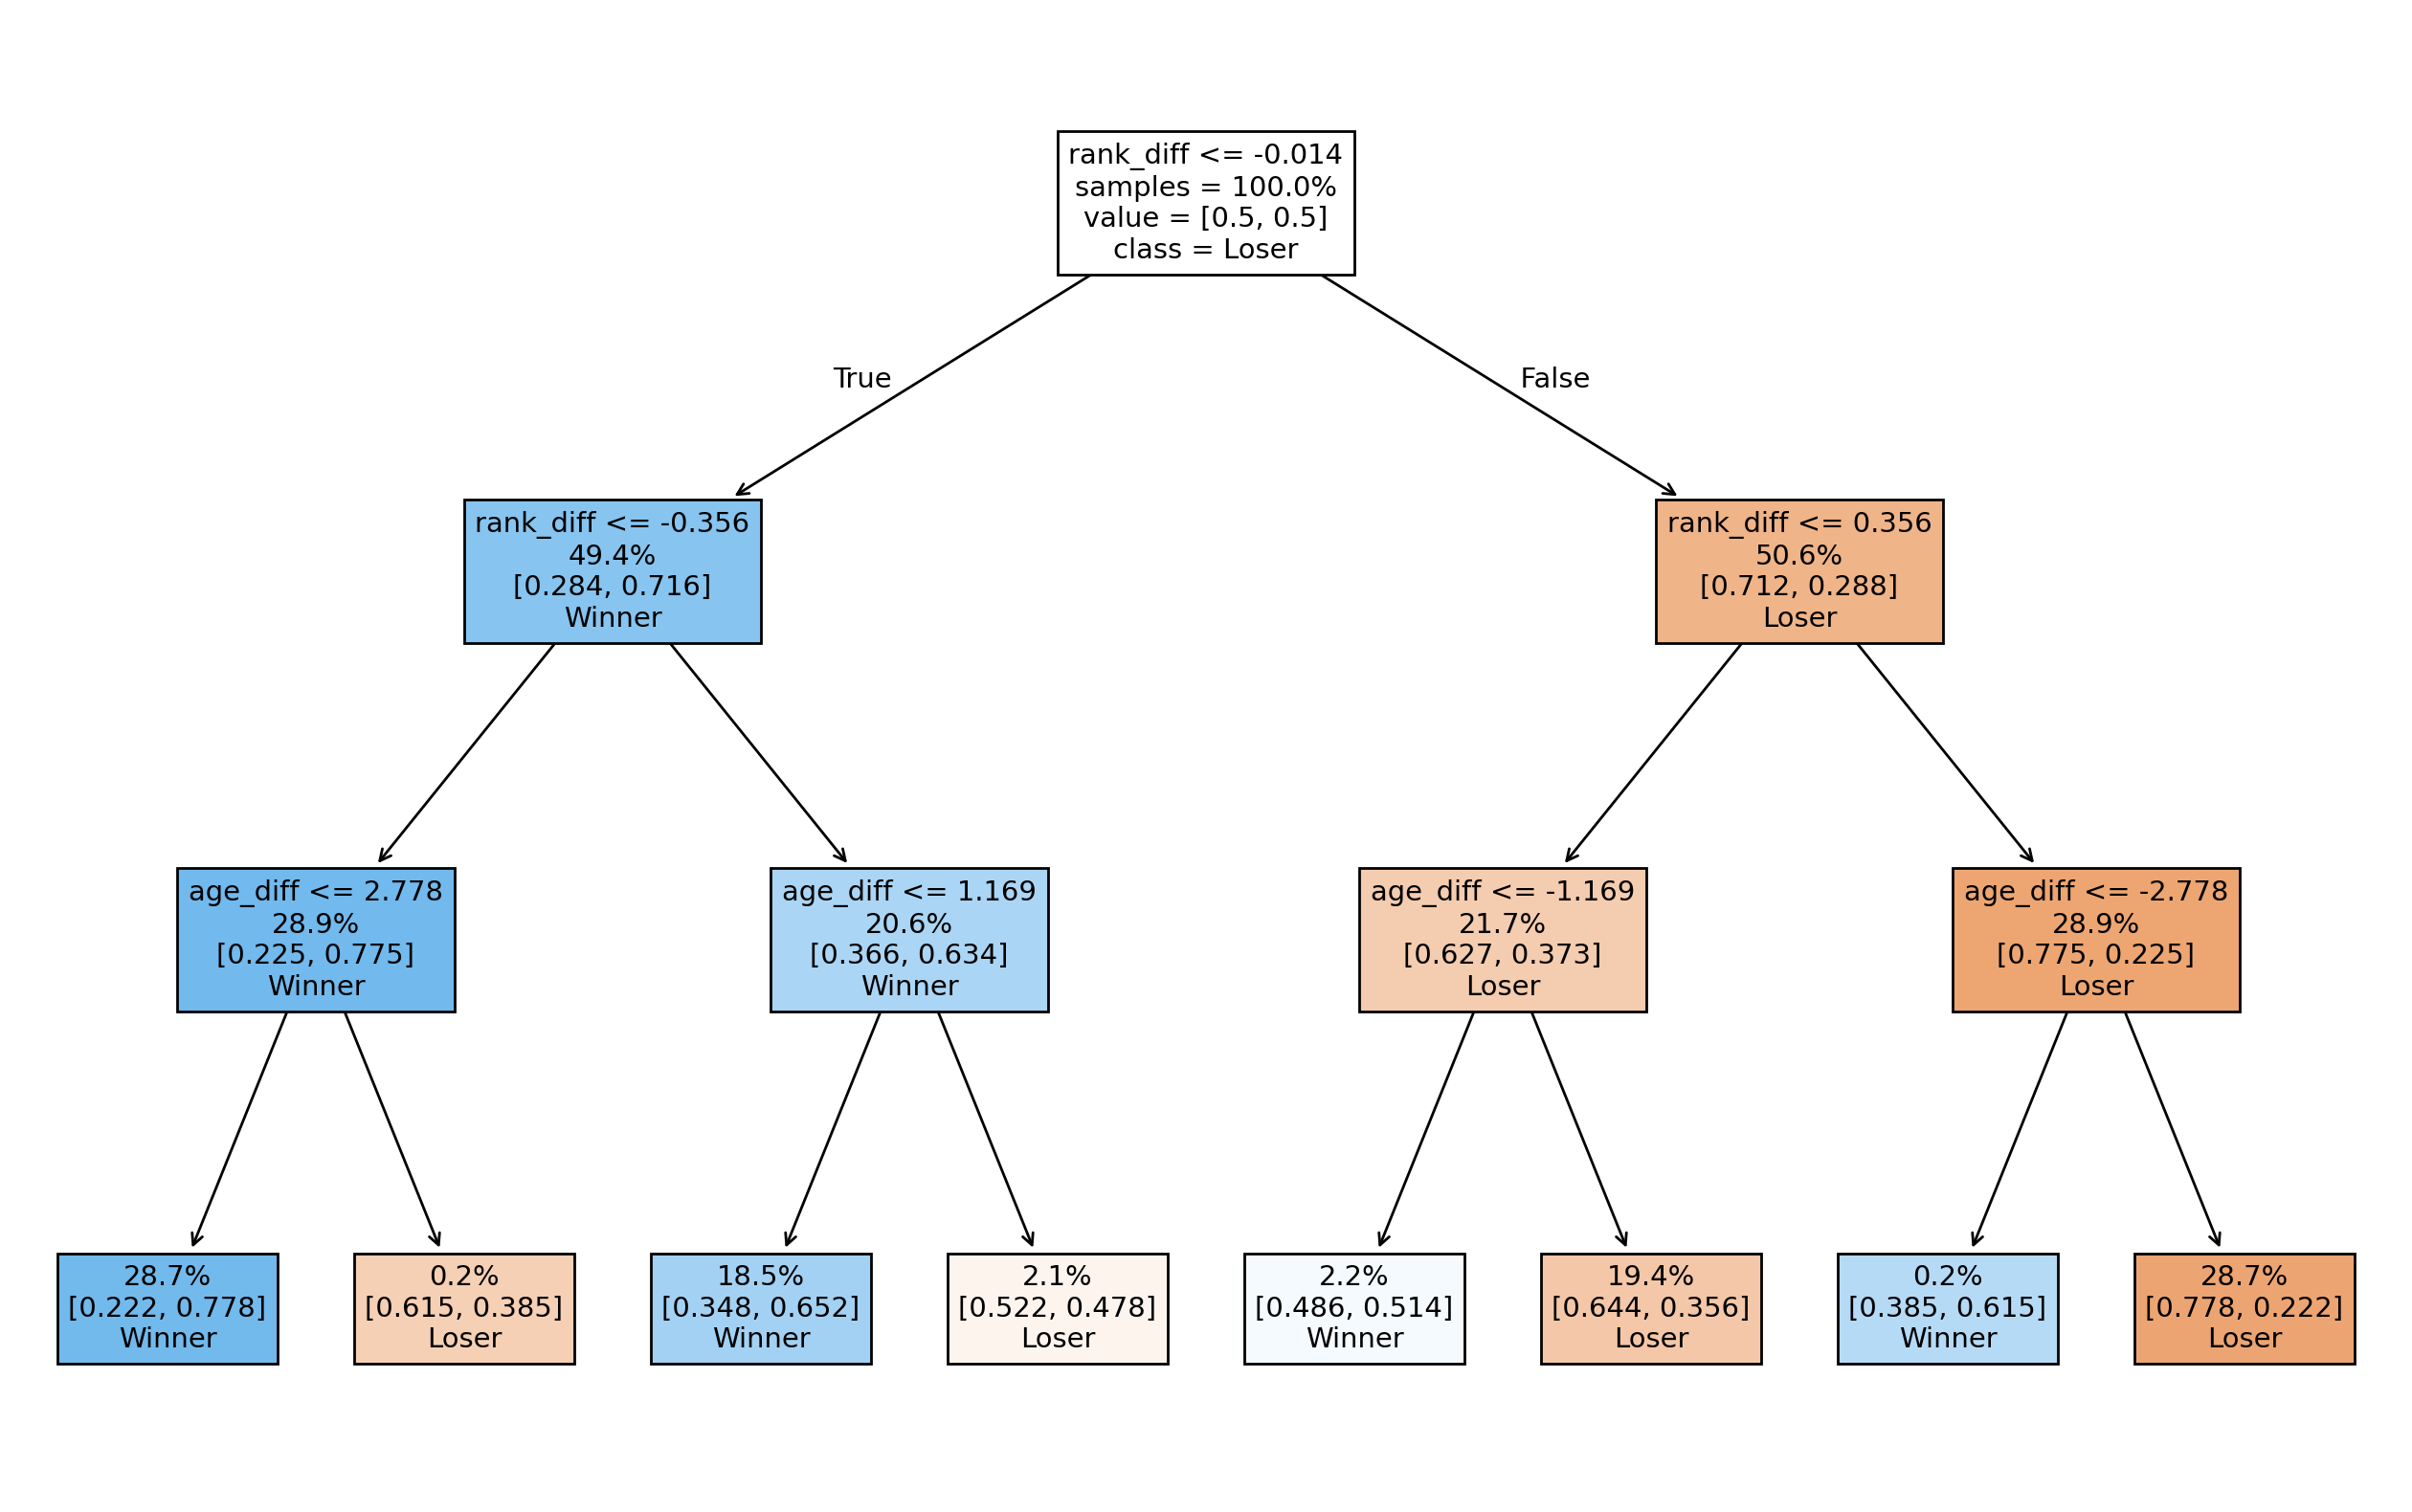

In [ ]:
plt.figure(dpi=200, figsize=(16,10))
plot_tree(tree_model,
          feature_names=features,
          class_names=['Loser', 'Winner'],
          label = 'root',
          filled=True,
          impurity=False,
          proportion=True,
          rounded=False)

In [30]:
French_Open_2025_file_path = '/content/drive/MyDrive/Sports Analysis/Roland_Garros_2025_Matchups.csv'
French_Open_2025_df = pd.read_csv(French_Open_2025_file_path)
French_Open_2025_df

,Round,Player 1,P1 Height (cm),P1 Age,P1 Rank,P1 Hand,Player 2,P2 Height (cm),P2 Age,P2 Rank,P2 Hand
0,R1,Jannik Sinner,191,23,1,R,Arthur Rinderknech,196,29,78,R
1,R1,Carlos Alcaraz,183,22,2,R,Giulio Zeppieri,183,23,120,L
2,R1,Alexander Zverev,198,28,3,R,Learner Tien,185,19,250,L
3,R1,Novak Djokovic,188,38,6,R,Mackenzie McDonald,178,30,55,R
4,R1,Jack Draper,193,23,5,L,Mattia Bellucci,183,23,150,L
5,R1,Taylor Fritz,196,27,4,R,Daniel Altmaier,188,26,66,R
6,R1,Casper Ruud,183,26,7,R,Albert Ramos-Vinolas,183,37,90,L
7,R1,Lorenzo Musetti,185,23,7,R,Yannick Hanfmann,193,33,60,R
8,R1,Holger Rune,188,22,8,R,Emilio Nava,185,23,120,R
9,R1,Alex de Minaur,180,26,9,R,Alexander Bublik,196,27,25,R
